## Preparación inicial

In [27]:
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import folium

In [2]:
xls = pd.ExcelFile('Prueba.xlsx')

In [3]:
sheet_names = xls.sheet_names
sheet_names

['Instrucciones', 'Glosario', 'PuntoPartida', 'PuntoLlegada', 'Siniestros']

In [4]:
punto_partida_df = pd.read_excel(xls, 'PuntoPartida')
punto_llegada_df = pd.read_excel(xls, 'PuntoLlegada')
siniestros_df = pd.read_excel(xls, 'Siniestros')

### Análisis Exploratorio
* Las coordenadas en ```punto_partida_df``` y ```punto_llegada_df``` están escritas en la notación *decimal degrees*.
* Las latitudes deben de ser números entre -90 y 90 grados.
* Las longitudes deben de ser números entre -180 y 180 grados.

#### punto_partida_df

In [5]:
punto_partida_df.dtypes

IDRuta                   object
NombreRuta               object
TipoUbicacion            object
Empresa                  object
HoraProgramadaSalida     object
Longitud                float64
Latitud                 float64
ValorMercancia            int64
IDConductor               int64
dtype: object

In [6]:
punto_partida_df.head()

,IDRuta,NombreRuta,TipoUbicacion,Empresa,HoraProgramadaSalida,Longitud,Latitud,ValorMercancia,IDConductor
0,a1,Relleno de Inventario,Bodega,Empresa 1,10:00:00,-100.316540,25.696300,150000,1
1,b2,Traslado de efectivo,Tienda,Empresa 1,09:00:00,-100.203823,25.663144,300000,1
2,c3,Relleno de Inventario,Bodega,Empresa 3,14:00:00,-100.145293,25.788839,1500000,1
3,d4,Relleno de Inventario,Bodega,Empresa 2,11:00:00,-100.367606,25.814914,200000,1
4,e5,Traslado de efectivo,Tienda,Empresa 3,15:00:00,-100.421277,25.744508,123000,1


#### punto_llegada_df

In [7]:
punto_llegada_df.dtypes

IDRuta             object
NombreRuta         object
TipoUbicacion      object
Empresa            object
HoraSalida         object
Longitud           object
Latitud           float64
ValorMercancia      int64
IDConductor         int64
dtype: object

* La columna ```longitud``` debería ser de tipo ```float64```.

In [8]:
punto_llegada_df.head()

,IDRuta,NombreRuta,TipoUbicacion,Empresa,HoraSalida,Longitud,Latitud,ValorMercancia,IDConductor
0,a1,Relleno de Inventario,Tienda,Empresa 1,10:03:00,-100.228542,25.550476,150000,1
1,b2,Traslado de efectivo,Banco,Banco 1,08:58:00,"-100.318156048963,",25.685163,300000,1
2,c3,Relleno de Inventario,Tienda,Empresa 3,14:10:00,-100.242414,25.664271,1500000,1
3,d4,Relleno de Inventario,Tienda,Empresa 2,11:00:19,-100.381548,25.664200,200000,1
4,e5,Traslado de efectivo,Banco,Banco 1,16:00:00,-100.318156,25.685163,123000,1


* Un valor en la columna *Longitud* no es un float valido pues termina con una coma.

In [9]:
# Remove any commas from the 'Longitud' column
punto_llegada_df['Longitud'] = punto_llegada_df['Longitud'].astype(str).str.replace(',', '', regex=False)

# Optionally, convert the cleaned column back to numeric if it's supposed to be numbers
punto_llegada_df['Longitud'] = pd.to_numeric(punto_llegada_df['Longitud'], errors='coerce')

In [10]:
punto_llegada_df.head()

,IDRuta,NombreRuta,TipoUbicacion,Empresa,HoraSalida,Longitud,Latitud,ValorMercancia,IDConductor
0,a1,Relleno de Inventario,Tienda,Empresa 1,10:03:00,-100.228542,25.550476,150000,1
1,b2,Traslado de efectivo,Banco,Banco 1,08:58:00,-100.318156,25.685163,300000,1
2,c3,Relleno de Inventario,Tienda,Empresa 3,14:10:00,-100.242414,25.664271,1500000,1
3,d4,Relleno de Inventario,Tienda,Empresa 2,11:00:19,-100.381548,25.664200,200000,1
4,e5,Traslado de efectivo,Banco,Banco 1,16:00:00,-100.318156,25.685163,123000,1


In [11]:
punto_llegada_df.dtypes

IDRuta             object
NombreRuta         object
TipoUbicacion      object
Empresa            object
HoraSalida         object
Longitud          float64
Latitud           float64
ValorMercancia      int64
IDConductor         int64
dtype: object

#### siniestros_df

In [12]:
siniestros_df.dtypes

FolioSiniestro       int64
Evento              object
Subtipo             object
UnidadOperativa     object
IDTienda           float64
IDVehiculo         float64
ValorPerdido         int64
Latitud            float64
Longitud           float64
dtype: object

In [13]:
siniestros_df.head()

,FolioSiniestro,Evento,Subtipo,UnidadOperativa,IDTienda,IDVehiculo,ValorPerdido,Latitud,Longitud
0,10001415,Robo,Con violencia,Tienda,4.0,NaN,84723,25.808908,-100.379278
1,10001213,Robo,Con violencia,Vehiculo,NaN,2.0,117041,25.799021,-100.386182
2,10001224,Robo,Sin violencia,Vehiculo,NaN,2.0,116400,25.797738,-100.381691
3,10001327,Robo,Sin violencia,Vehiculo,NaN,3.0,117888,25.786821,-100.379681
4,10001316,Robo,Con violencia,Tienda,3.0,NaN,73533,25.777179,-100.180762


## Calcular driving distance

In [14]:
rutas_df = pd.merge(
    punto_partida_df,
    punto_llegada_df,
    on=['IDRuta', 'NombreRuta', 'ValorMercancia', 'IDConductor'],
    suffixes=('Partida', 'Llegada')  # To differentiate columns if any aren't shared
)

# Show the merged DataFrame
rutas_df

,IDRuta,NombreRuta,TipoUbicacionPartida,EmpresaPartida,HoraProgramadaSalida,LongitudPartida,LatitudPartida,ValorMercancia,IDConductor,TipoUbicacionLlegada,EmpresaLlegada,HoraSalida,LongitudLlegada,LatitudLlegada
0,a1,Relleno de Inventario,Bodega,Empresa 1,10:00:00,-100.316540,25.696300,150000,1,Tienda,Empresa 1,10:03:00,-100.228542,25.550476
1,b2,Traslado de efectivo,Tienda,Empresa 1,09:00:00,-100.203823,25.663144,300000,1,Banco,Banco 1,08:58:00,-100.318156,25.685163
2,c3,Relleno de Inventario,Bodega,Empresa 3,14:00:00,-100.145293,25.788839,1500000,1,Tienda,Empresa 3,14:10:00,-100.242414,25.664271
3,d4,Relleno de Inventario,Bodega,Empresa 2,11:00:00,-100.367606,25.814914,200000,1,Tienda,Empresa 2,11:00:19,-100.381548,25.664200
4,e5,Traslado de efectivo,Tienda,Empresa 3,15:00:00,-100.421277,25.744508,123000,1,Banco,Banco 1,16:00:00,-100.318156,25.685163


## Calculate Driving Distance

In [15]:
def get_driving_distance(start_coords, end_coords):
    # Unpack the coordinates
    start_lon, start_lat = start_coords
    end_lon, end_lat = end_coords

    # OSRM API endpoint
    url = f"http://router.project-osrm.org/route/v1/driving/{start_lon},{start_lat};{end_lon},{end_lat}?overview=false"

    # Send the request to OSRM API
    response = requests.get(url)
    
    # Parse the JSON response
    data = response.json()

    if data and 'routes' in data:
        # Extract the distance in meters
        distance = data['routes'][0]['distance']
        # Extract the duration in seconds
        duration = data['routes'][0]['duration']
        return distance, duration
    else:
        return None, None

# Example usage with coordinates from your spreadsheet
start_coords = (-100.31654, 25.6963)  # Starting point coordinates
end_coords = (-100.228542, 25.550476)  # Destination point coordinates

distance, duration = get_driving_distance(start_coords, end_coords)
print(f"Driving Distance: {distance} meters, Duration: {duration} seconds")

Driving Distance: 20482.1 meters, Duration: 1054.3 seconds


In [16]:
# Apply function to each row in rutas_df
def apply_driving_distance(row):
    # Extract the starting and ending coordinates
    start_coords = (row['LongitudPartida'], row['LatitudPartida'])
    end_coords = (row['LongitudLlegada'], row['LatitudLlegada'])
    
    # Get the driving distance and duration
    distance, duration = get_driving_distance(start_coords, end_coords)
    
    return pd.Series([distance, duration], index=['DistanceMeters', 'DurationSeconds'])

# Apply the function to every row and store results in new columns
rutas_df[['DistanceMeters', 'DurationSeconds']] = rutas_df.apply(apply_driving_distance, axis=1)

In [17]:
rutas_df

,IDRuta,NombreRuta,TipoUbicacionPartida,EmpresaPartida,HoraProgramadaSalida,LongitudPartida,LatitudPartida,ValorMercancia,IDConductor,TipoUbicacionLlegada,EmpresaLlegada,HoraSalida,LongitudLlegada,LatitudLlegada,DistanceMeters,DurationSeconds
0,a1,Relleno de Inventario,Bodega,Empresa 1,10:00:00,-100.316540,25.696300,150000,1,Tienda,Empresa 1,10:03:00,-100.228542,25.550476,20482.1,1054.3
1,b2,Traslado de efectivo,Tienda,Empresa 1,09:00:00,-100.203823,25.663144,300000,1,Banco,Banco 1,08:58:00,-100.318156,25.685163,13728.1,1052.4
2,c3,Relleno de Inventario,Bodega,Empresa 3,14:00:00,-100.145293,25.788839,1500000,1,Tienda,Empresa 3,14:10:00,-100.242414,25.664271,23049.7,1570.3
3,d4,Relleno de Inventario,Bodega,Empresa 2,11:00:00,-100.367606,25.814914,200000,1,Tienda,Empresa 2,11:00:19,-100.381548,25.664200,25139.5,1597.2
4,e5,Traslado de efectivo,Tienda,Empresa 3,15:00:00,-100.421277,25.744508,123000,1,Banco,Banco 1,16:00:00,-100.318156,25.685163,14105.0,928.2


## Visualizar ```siniestros_df```

In [18]:
siniestros_df.tail(10)

,FolioSiniestro,Evento,Subtipo,UnidadOperativa,IDTienda,IDVehiculo,ValorPerdido,Latitud,Longitud
45,10001412,Robo,Sin violencia,Tienda,4.0,NaN,23706,25.673092,-100.230099
46,10001240,Vandalismo,NaN,Tienda,2.0,NaN,6217,25.672449,-100.317756
47,10001144,Vandalismo,NaN,Vehiculo,NaN,1.0,56972,25.669278,-100.235860
48,10001151,Delincuencia Organizada,NaN,Tienda,1.0,NaN,0,25.668250,-100.303949
49,10001119,Robo,Con violencia,Vehiculo,NaN,1.0,7348,25.668106,-100.317987
50,10001154,Delincuencia Organizada,NaN,Tienda,1.0,NaN,0,25.665895,-100.299721
51,10001133,Robo,Sin violencia,Vehiculo,NaN,1.0,63773,25.664839,-100.237429
52,10001152,Delincuencia Organizada,NaN,Tienda,1.0,NaN,0,25.653002,-100.291979
53,10001223,Robo,Con violencia,Tienda,2.0,NaN,8058,25.619191,-100.270167
54,1000143,Robo,Con violencia,Tienda,4.0,NaN,2022,25.597487,-100.260996


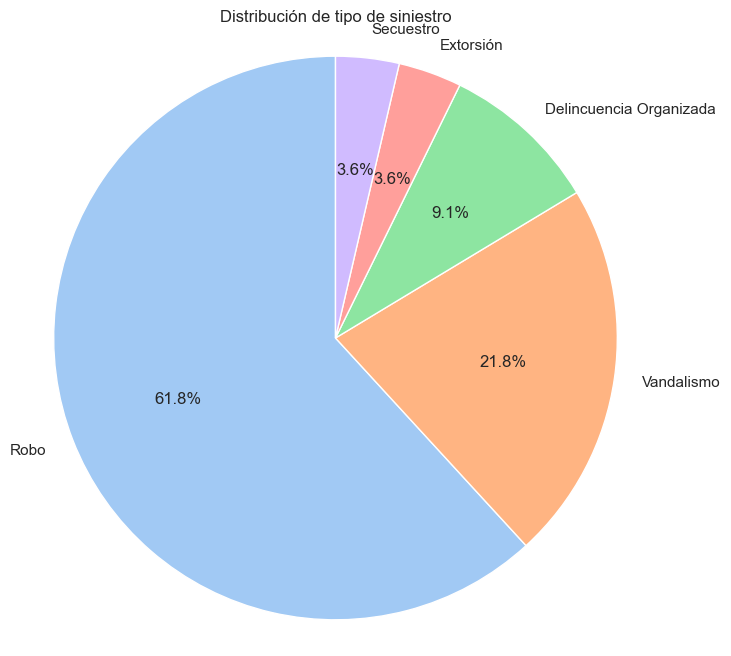

In [21]:


# Apply Seaborn theme to Matplotlib plots
sns.set_theme()

# Assuming 'TipoSiniestro' is the column that contains the siniestro types
# Count the occurrences of each type
siniestro_counts = siniestros_df['Evento'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))  # Optional: Set the figure size
plt.pie(siniestro_counts, labels=siniestro_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
plt.title('Distribución de tipo de siniestro')
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle
plt.show()


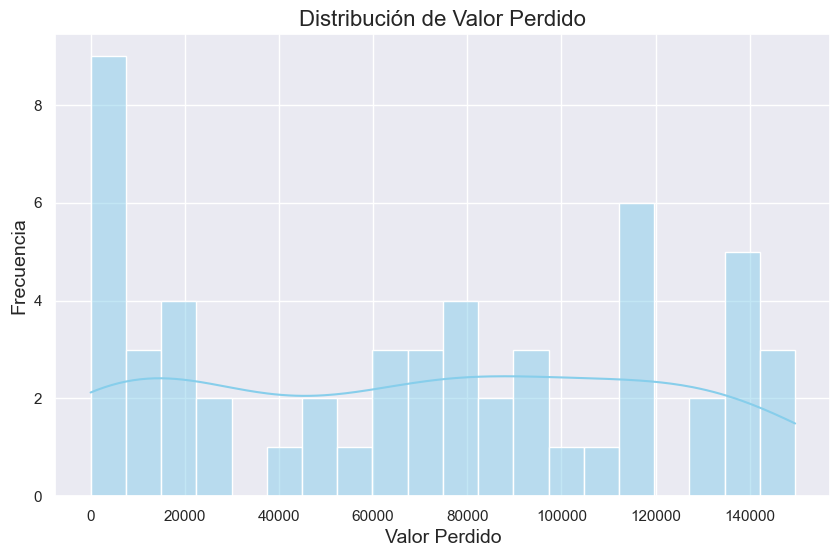

In [26]:
# Set Seaborn theme for better aesthetics
sns.set_theme()

# Plot the histogram of "Valor Perdido"
plt.figure(figsize=(10, 6))  # Optional: Set figure size
sns.histplot(siniestros_df['ValorPerdido'], bins=20, kde=True, color='skyblue')

# Add titles and labels
plt.title('Distribución de Valor Perdido', fontsize=16)
plt.xlabel('Valor Perdido', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)

# Show the plot
plt.show()

In [34]:
eventos = siniestros_df.Evento.unique()
eventos

array(['Robo', 'Vandalismo', 'Extorsión', 'Secuestro',
       'Delincuencia Organizada'], dtype=object)

In [35]:
colors = ['blue', 'green', 'red', 'yellow', 'orange']

In [36]:
event_colors = dict(zip(eventos, colors))
event_colors

{'Robo': 'blue',
 'Vandalismo': 'green',
 'Extorsión': 'red',
 'Secuestro': 'yellow',
 'Delincuencia Organizada': 'orange'}

In [43]:
# Create a base map centered around the average coordinates
m = folium.Map(location=[siniestros_df['Latitud'].mean(), siniestros_df['Longitud'].mean()], zoom_start=12)

# Loop through the DataFrame to add markers for each event
for index, row in siniestros_df.iterrows():
    folium.Marker(
        location=[row['Latitud'], row['Longitud']],
        popup=row['Evento'],  # This shows the event type on marker click
        icon=folium.Icon(color=event_colors.get(row['Evento'], 'gray'))  # Default to gray if type not found
    ).add_to(m)

# Save the map to an HTML file
m.save('siniestros_map.html')

# If you want to display it in a Jupyter notebook, you can use:
# m


/var/folders/gf/8nm7hnt56930dgzv4ygl2z8w0000gn/T/ipykernel_3390/38999998.py:9: UserWarning: color argument of Icon should be one of: {'purple', 'orange', 'pink', 'black', 'darkpurple', 'darkred', 'lightgreen', 'gray', 'beige', 'red', 'lightred', 'cadetblue', 'green', 'white', 'darkblue', 'darkgreen', 'lightblue', 'lightgray', 'blue'}.
  icon=folium.Icon(color=event_colors.get(row['Evento'], 'gray'))  # Default to gray if type not found


In [45]:
legend_items = ''.join(
    f'<li><span style="background-color: {color}; width: 20px; height: 20px; display: inline-block;"></span> {event_type}</li>'
    for event_type, color in event_colors.items()
)

legend_html = f'''
    <div style="position: fixed; 
                top: 10px; left: 10px; 
                width: 150px; height: auto; 
                z-index: 1000; 
                background-color: white; 
                border:2px solid grey; 
                border-radius:5px; 
                padding: 10px;">
        <h4 style="margin: 0;">Tipo de Evento</h4>
        <ul style="list-style-type:none; padding: 0;">
            {legend_items}
        </ul>
    </div>
'''

# Add the legend to the map
m.get_root().html.add_child(folium.Element(legend_html))


# Save the map to an HTML file
m.save('siniestros_map_with_legend.html')

In [40]:
import io
from PIL import Image
import selenium

img_data = m._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('image.png')